# FSM: First Simple Model 

# Overview

# Business Problem

# Data Understanding

Due to the size of the dataset, I can not directly push it to my online repository. The **dataset can be accessed here**:

- [2022 BRFSS Survey Data and Documentation](https://www.cdc.gov/brfss/annual_data/annual_2022.html)

The **codebook** can be accessed here:

- [LLCP 2022: Codebook Report](/Users/emmascotson/Documents/capstone_flatiron/data/Codebook_Report.pdf)

# Data Preparation

# Modeling

# Evaluation

In [64]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [2]:
import os
print(os.getcwd())
# List files in the current directory
print(os.listdir('.'))

/Users/emmascotson/Documents/capstone_flatiron/notebooks
['Capstone.ipynb', '.ipynb_checkpoints']


# Loading the Data

In [3]:
# Specify the full path to the XPT file
file_path = '/Users/emmascotson/Documents/capstone_flatiron/data/diabetes.xpt'

# Attempt to read the XPT file
try:
    data = pd.read_sas(file_path, format='xport')
    print(data.head())
except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

   _STATE  FMONTH        IDATE IMONTH   IDAY    IYEAR  DISPCODE  \
0     1.0     1.0  b'02032022'  b'02'  b'03'  b'2022'    1100.0   
1     1.0     1.0  b'02042022'  b'02'  b'04'  b'2022'    1100.0   
2     1.0     1.0  b'02022022'  b'02'  b'02'  b'2022'    1100.0   
3     1.0     1.0  b'02032022'  b'02'  b'03'  b'2022'    1100.0   
4     1.0     1.0  b'02022022'  b'02'  b'02'  b'2022'    1100.0   

           SEQNO          _PSU  CTELENM1  ...  _SMOKGRP  _LCSREC  DRNKANY6  \
0  b'2022000001'  2.022000e+09       1.0  ...       4.0      NaN       2.0   
1  b'2022000002'  2.022000e+09       1.0  ...       4.0      NaN       2.0   
2  b'2022000003'  2.022000e+09       1.0  ...       4.0      NaN       2.0   
3  b'2022000004'  2.022000e+09       1.0  ...       3.0      2.0       2.0   
4  b'2022000005'  2.022000e+09       1.0  ...       4.0      NaN       1.0   

       DROCDY4_  _RFBING6      _DRNKWK2  _RFDRHV8  _FLSHOT7  _PNEUMO3  \
0  5.397605e-79       1.0  5.397605e-79       1.0      

In [4]:
data.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_SMOKGRP,_LCSREC,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4
0,1.0,1.0,b'02032022',b'02',b'03',b'2022',1100.0,b'2022000001',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,1.0,2.0,2.0
1,1.0,1.0,b'02042022',b'02',b'04',b'2022',1100.0,b'2022000002',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,2.0,2.0,2.0
2,1.0,1.0,b'02022022',b'02',b'02',b'2022',1100.0,b'2022000003',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,2.0
3,1.0,1.0,b'02032022',b'02',b'03',b'2022',1100.0,b'2022000004',2.022000e+09,1.0,...,3.0,2.0,2.0,5.397605e-79,1.0,5.397605e-79,1.0,9.0,9.0,2.0
4,1.0,1.0,b'02022022',b'02',b'02',b'2022',1100.0,b'2022000005',2.022000e+09,1.0,...,4.0,NaN,1.0,1.000000e+01,1.0,1.400000e+02,1.0,NaN,NaN,2.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Columns: 328 entries, _STATE to _AIDTST4
dtypes: float64(323), object(5)
memory usage: 1.1+ GB


# Preprocessing

## Filtering for Genetic/Involuntary 

I'll keep a few of the behavioral categories that have clear severe impacts on physical health, such as smoking and drinking habits -- so I can better compare whether someone's symptoms might be related to disease-prone genetics inherited from their parents or the result of smoking a pack of cigarettes a day for the past 40 years. 

Since I'll be adding many other behavioral columns in later, for our larger model, I'll be sparing for this preliminary model.

In [6]:
columns_to_keep = ['CADULT1', 'CELLSEX1', 'CSTATE1', 'SEXVAR', 'GENHLTH', 'PHYSHLTH', 'PRIMINSR', 
                   'PERSDOC3', 'MEDCOST1', 'RMVTETH4', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3',
                   'ASTHNOW', 'CHCSCNC1', 'CHCOCNC1', 'PREGNANT', 'WEIGHT2', 'HEIGHT3', 'DEAF',
                   'BLIND', 'DECIDE', 'DIFFWALK', 'CERVSCRN', 'SMOKE100', 'SMOKDAY2', 'LCSCTSC1',
                   '_STATE', 'LCSSCNCR', 'PDIABTS1', 'PREDIAB2', 'DIABETE4', 'DIABTYPE', 'INSULIN1',
                   'CHKHEMO3', 'EYEEXAM1', 'DIABEYE1', 'FEETSORE', 'TOLDCFS', 'HAVECFS', 'COPDCOGH',
                   'COPDFLEM', 'COPDBTST', 'CNCRDIFF', 'CNCRAGE', 'CNCRTYP2', 'CSRVDOC1', 'CSRVSUM',
                   'CSRVRTRN', 'PSATEST1', 'CIMEMLOS', 'CDDISCUS', 'CAREGIV1', 'CRGVREL4', 'CRGVPRB3',
                   'CRGVALZD', 'LSATISFY', 'ASBIRDUC', 'BIRTHSEX', 'TRNSGNDR', 'RRCLASS3', 'RRHCARE4',
                   'RRPHYSM2', '_METSTAT', '_URBSTAT', 'MSCODE', '_IMPRACE', '_CHISPNC', '_RFHLTH',
                   '_PHYS14D', '_HLTHPLN', '_HCVU652', '_MICHD', '_LTASTH1', '_CASTHM1', '_ASTHMS1',
                   '_DRDXAR2', '_MRACE2', '_HISPANC', '_RACE1', '_RACEG22', '_RACEGR4', '_SEX', '_AGEG5YR',
                   '_AGE65YR', '_AGE80', '_AGE_G', 'HTIN4', 'WTKG3', '_BMI5', '_BMI5CAT', '_RFBMI5', 
                   '_INCOMG1', '_SMOKER3', '_YRSSMOK', '_SMOKGRP', '_LCSREC', '_RFBING6', '_RFDRHV8']

In [7]:
# Creating new filtered dataframe for First Simple Model

fsm = data[columns_to_keep]

In [8]:
fsm.head()

,CADULT1,CELLSEX1,CSTATE1,SEXVAR,GENHLTH,PHYSHLTH,PRIMINSR,PERSDOC3,MEDCOST1,RMVTETH4,...,_BMI5,_BMI5CAT,_RFBMI5,_INCOMG1,_SMOKER3,_YRSSMOK,_SMOKGRP,_LCSREC,_RFBING6,_RFDRHV8
0,NaN,NaN,NaN,2.0,2.0,88.0,99.0,1.0,2.0,NaN,...,NaN,NaN,9.0,9.0,4.0,NaN,4.0,NaN,1.0,1.0
1,NaN,NaN,NaN,2.0,1.0,88.0,3.0,2.0,2.0,NaN,...,2657.0,3.0,2.0,3.0,4.0,NaN,4.0,NaN,1.0,1.0
2,NaN,NaN,NaN,2.0,2.0,2.0,1.0,1.0,2.0,NaN,...,2561.0,3.0,2.0,6.0,4.0,NaN,4.0,NaN,1.0,1.0
3,NaN,NaN,NaN,2.0,1.0,88.0,99.0,1.0,2.0,NaN,...,2330.0,2.0,1.0,9.0,2.0,56.0,3.0,2.0,1.0,1.0
4,NaN,NaN,NaN,2.0,4.0,2.0,7.0,2.0,2.0,NaN,...,2177.0,2.0,1.0,3.0,4.0,NaN,4.0,NaN,1.0,1.0


In [9]:
fsm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 100 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   CADULT1   349080 non-null  float64
 1   CELLSEX1  349079 non-null  float64
 2   CSTATE1   349072 non-null  float64
 3   SEXVAR    445132 non-null  float64
 4   GENHLTH   445129 non-null  float64
 5   PHYSHLTH  445127 non-null  float64
 6   PRIMINSR  445128 non-null  float64
 7   PERSDOC3  445130 non-null  float64
 8   MEDCOST1  445128 non-null  float64
 9   RMVTETH4  443769 non-null  float64
 10  CVDINFR4  445128 non-null  float64
 11  CVDCRHD4  445130 non-null  float64
 12  CVDSTRK3  445130 non-null  float64
 13  ASTHMA3   445130 non-null  float64
 14  ASTHNOW   66694 non-null   float64
 15  CHCSCNC1  445130 non-null  float64
 16  CHCOCNC1  445129 non-null  float64
 17  PREGNANT  79018 non-null   float64
 18  WEIGHT2   429231 non-null  float64
 19  HEIGHT3   428077 non-null  float64
 20  DEA

## Nulls

Huh! It seems like there are some columns with completely missing values. Let's re-print the columns in ascending order of non-null values to reference back to the Codebook and examine whether our Null values are accurate. 

In [10]:
# Get non-null counts for each column
non_null_counts = fsm.notnull().sum()

# Sort columns by non-null counts in ascending order
sorted_columns = non_null_counts.sort_values().index

# Reorder DataFrame columns based on sorted order
fsm_sorted = fsm[sorted_columns]

# Print info of the sorted DataFrame
print(fsm_sorted.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 100 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   HAVECFS   0 non-null       float64
 1   TOLDCFS   0 non-null       float64
 2   PSATEST1  7180 non-null    float64
 3   COPDBTST  7232 non-null    float64
 4   COPDFLEM  7262 non-null    float64
 5   COPDCOGH  7269 non-null    float64
 6   CDDISCUS  7400 non-null    float64
 7   CSRVRTRN  9771 non-null    float64
 8   CSRVSUM   9783 non-null    float64
 9   CSRVDOC1  9807 non-null    float64
 10  FEETSORE  12600 non-null   float64
 11  DIABEYE1  12600 non-null   float64
 12  EYEEXAM1  12600 non-null   float64
 13  CHKHEMO3  12600 non-null   float64
 14  INSULIN1  12600 non-null   float64
 15  DIABTYPE  12600 non-null   float64
 16  CRGVALZD  17300 non-null   float64
 17  CRGVPRB3  19472 non-null   float64
 18  CRGVREL4  19634 non-null   float64
 19  CNCRTYP2  22544 non-null   float64
 20  CNC

##### HAVECFS and TOLDCFS

The codebook confirms that the data is completely missing for all rows in these columns, which indicate a person's status with regards to having or being told they have **Chronic Fatigue Syndrome (CFS)** or **Myalgic Encephalomyelitis**. 

##### PSATEST1

Survey Question: *Have you ever had a P.S.A. test?*

*PSA test*: measures the amount of PSA in a man's blood to help screen for and monitor prostate cancer.

According to Cleveland Clinic PSA tests are very common. Which leaves us to wonder why so many of these values are Nulls -- certainly a far greater number than the amount of men that were surveyed in the dataset. 


##### COPDCOGH AND COPDFLEM

Survey Question: *During the past three months, did you have a cough and/or cough up phlegm or mucus on most days? 

These columns might be more of the **hindsight bias** symptoms I was referring to early, rather than prior warning signs. It's not a big deal if we have a lot of Nulls for these, we have other genetic and physical factors that will be far more important to our model. 

##### CDDISCUS

Survey Question: Have you are anyone else discussed your confusion or memory loss with a health care professional? 

Again, not one of our most important features, so no need to stress that there are a lot of Nulls. 

An interesting takeaway from the Codebook Report with regards to this feature: the **non**-missing values seemed to be pretty balanced between our two main class...3,432 'Yes' and 3,862 'No'. 

##### CSVRTRN, CSRVSUM

Survey Question CSVRTRN: Have you ever received instructions from a doctor, nurse, or other health professional about where you should return or who you should see for routine cancer check-
ups after completing treatment for cancer?

Survey Question CSRVSUM: Did any doctor, nurse, or other health professional ever give you a written summary of all the cancer treatments that you received?

These are sort of behavioral questions, as they bleed into the question of whether or not people choose to incorporate doctor's visits into their lifestyle routines. I thought they might be helpful in isolating whether people had **reasons** to go to the doctor (due to underlying genetic conditions), but there are other features we have that are more suitable for this anyway. 

##### CSRVDOC1 

Survey Question: What type of doctor provides the majority of your health care? Is it a….

This could still be useful, even if we have Nulls, to identify any specialized possibly genetic reasons a person requires specific medical care from a particular kind of doctor. But again, not entirely important compared to other features. So it's okay that we have mostly Nulls.

### Moving On

The rest of our columns have over 10,000 non-null values. To save time, I'll keep moving for now and examine these as I go if need be.

## Cleaning: Lowercase Column Names

Let's **lowercase all the column names**, to increase readability. 

#### Other Cleaning

There's such a large number of columnns, even in this smaller FSM -- I want to optomize time by moving on to explore the data and continuing to "clean as I go" if I run into any other issues. Rather than assessing any need to clean answer values for each column right now as well. 

Furthermore, from what I've seen in the Codebook, this dataset is extremely well-organized compared to some past datasets I've worked with. I therefore feel confident in assuming that most of the answer-values in the rows themselves are pretty clean, and I can optomize time by moving forward and dealing with any other issues as they arise. 

In [11]:
# lowercasing column names
fsm.columns = fsm.columns.str.lower()

# Codebook Key Dictionary: 'codebook_key'

To minimize the amount of time I have to refer back to the Codebook and/or scroll up and down through this notebook to reference old markdowns...I'm going to make a **dictionary called 'codebook_key'** which contains column names and the meanings of their answer values as key-value pairs. 

I will do this as I go, then print 'codebook_key' whenever I need to refer back. 

# EDA

# Target Variable: diabete4

**Target Survey Question**: (Ever told) (you had) diabetes? (If ´Yes´ and respondent is female, ask ´Was this only when you were pregnant?´. If Respondent says pre-diabetes or borderline diabetes, use response code 4.)

**Target Answer Values**...

In [87]:
# ADDING TO CODEBOOK DICTIONARY
codebook_key = {
    'diabete4': {
        'Question': "(Ever told) (you had) diabetes? (If 'Yes' and respondent is female, ask 'Was this only when you were pregnant?´.",
        'Answers': {
        1: 'Yes',
        2: 'Yes, but female told only during pregnancy',
        3: 'No',
        4: 'No, pre-diabetes or boderline diabetes',
        7: 'Dont know/Not sure',
        9: 'Refused',
        'BLANK': 'Not asked or Missing'
        }
    }
}

**Nulls**

445129 non-null values, 3 missing values

Few! Our target class barely has any missingness. And looking at the *frequency values* in the Codebook, there are only 1084 of the 'Don't know/Not Sure' and 'Refused' values combined. Obviously the greater the volume of rows and data with regards to the target variable, the better.

I'll print the frequencies of the other values shortly. 

### Columns to Contextualize Target: pdiabts1, prediab2, diabtype

##### pdiabts1

Survey Question: When was the last time you had a blood test for high blood sugar or diabetes by a doctor, nurse, or other health professional?

140,248 non-null, 304,884 missing malues

##### prediab2

Survey Question: Has a doctor or other health professional ever told you that you had prediabetes or borderline diabetes? (If “Yes” and respondent is female, ask: “Was this only when you were pregnan

140,222 non-null, 304,910 missing values

#### diabtype

Survey Question: According to your doctor or other health professional, what type of diabetes do you have?

Answer Values: *Type 1, Type 2, Don't know/Not Sure, Refused, Not asked or Missing*

This column could be a good way to expand the target variable with more specifity, as I move onto to larger more complex models after this FSM. If I have time, I can start to develop a chained model that not only predicts whether someone develops diabetes, but further predicts which type they will progress to. Otherwise, I can use it to contextualize my findings.

12,600 non-null, 432,532 missing values

In [12]:
fsm['diabete4'].value_counts(normalize=True)

diabete4
3.0    0.828349
1.0    0.137394
4.0    0.023205
2.0    0.008618
7.0    0.001714
9.0    0.000721
Name: proportion, dtype: float64

#### Imbalanced Target

82.83% of the target variable is 'No', and only 13.74% of the target variable is 'Yes'. 

I'll have to keep this in mind when building the model!

## Feature Selection & Importance 

### Linear Relationship

Because I'm only looking at concrete genetic factors, there might be a stronger **linear relationship** between these features and whether a person has diabetes, compared with the behavioral/lifestyle choices a person can make that can create messier/more complex non-linear relationships in the data. 

Let's print the **correlation coefficients** between each of our features and our target variable to look for signs of predictive importance, as well as a **correlation matrix** to look for signs of multicollinearity between features. 

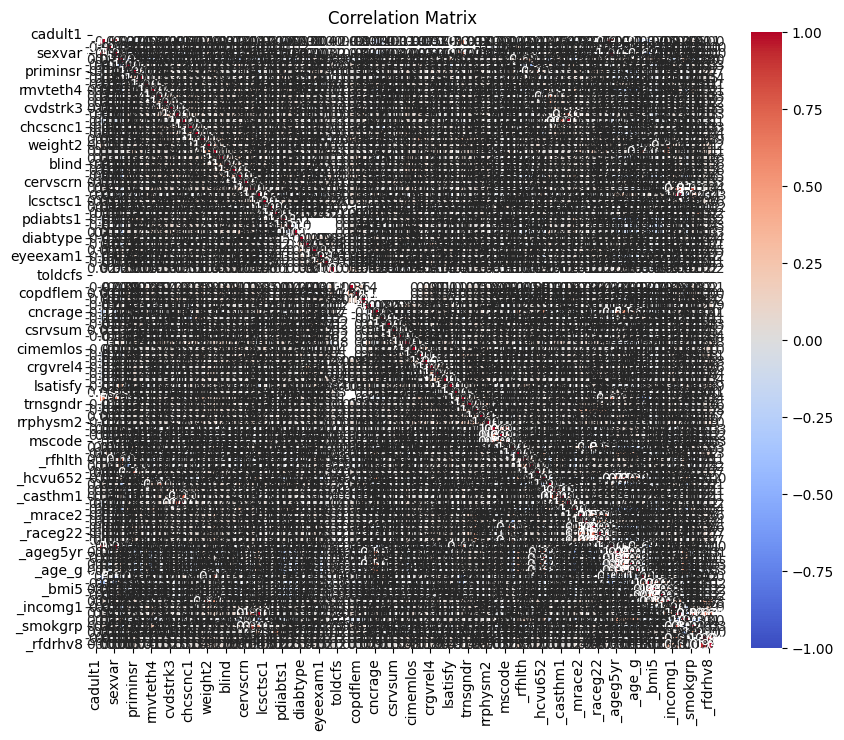

In [13]:
# printing correlation matrix

correlation_matrix = fsm.corr()

plt.figure(figsize=(10, 8))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Woah!! This is totally uninterpretable. 

Let's try two things:

1) Printing the **pairs of features with the highest correlation** values
2) Using **clustering** to identify **groups of similar features**, and printing smaller corrrelation matrices based on these groups.

#### Printing Pairs of Correlated Features

In [14]:
# Assuming 'fsm' is your DataFrame
correlation_matrix = fsm.corr().abs()  # Take the absolute value to focus on the strength of correlations
np.fill_diagonal(correlation_matrix.values, 0)  # Set diagonal to 0 to ignore self-correlations

# Find the indices of the maximum correlations
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Display the top pairs
print(high_corr_pairs.head(10))

smokday2  _smoker3    0.997373
_smoker3  smokday2    0.997373
_sex      sexvar      0.997272
sexvar    _sex        0.997272
_asthms1  asthnow     0.994266
asthnow   _asthms1    0.994266
_age_g    _age80      0.973894
_age80    _age_g      0.973894
_ageg5yr  _age80      0.964545
_age80    _ageg5yr    0.964545
dtype: float64


Woah! A ton of HIGHLY correlated pairs. Let's print a greater number so we can examine further.

In [15]:
# Assuming 'fsm' is your DataFrame
correlation_matrix = fsm.corr().abs()  # Take the absolute value to focus on the strength of correlations
np.fill_diagonal(correlation_matrix.values, 0)  # Set diagonal to 0 to ignore self-correlations

# Find the indices of the maximum correlations
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Display the top pairs
print(high_corr_pairs.head(50))

smokday2  _smoker3    0.997373
_smoker3  smokday2    0.997373
_sex      sexvar      0.997272
sexvar    _sex        0.997272
_asthms1  asthnow     0.994266
asthnow   _asthms1    0.994266
_age_g    _age80      0.973894
_age80    _age_g      0.973894
_ageg5yr  _age80      0.964545
_age80    _ageg5yr    0.964545
_racegr4  _race1      0.952064
_race1    _racegr4    0.952064
cellsex1  sexvar      0.950968
sexvar    cellsex1    0.950968
cellsex1  _sex        0.948230
_sex      cellsex1    0.948230
_ageg5yr  _age_g      0.942386
_age_g    _ageg5yr    0.942386
_rfbing6  _rfdrhv8    0.939160
_rfdrhv8  _rfbing6    0.939160
_hcvu652  _age65yr    0.916876
_age65yr  _hcvu652    0.916876
_metstat  mscode      0.865803
mscode    _metstat    0.865803
_racegr4  _raceg22    0.861555
_raceg22  _racegr4    0.861555
wtkg3     _bmi5       0.859557
_bmi5     wtkg3       0.859557
_smokgrp  _smoker3    0.856792
_smoker3  _smokgrp    0.856792
_rfbmi5   _bmi5cat    0.854818
_bmi5cat  _rfbmi5     0.854818
        

Wow. Even printing the top 50, as opposed to the top 10, all the features are highly correlated.

We can't move on to **K-Means Clustering** to group features, with so many (or really any) NaNs still in the dataframe. Let's harness domain knowledge from the Codebook to cut down correlated features, then printed correlated pairs again, then move on to clustering if possible.

### Correlated Pairs: Using Codebook

It's clear there are highly interrelated groups of features based on the correlated pairs printed above. Rather than wasting time identifying each of these features and their meaning in a markdown, I'll identify the group "category" (such as 'Smoking Habits'), and refer to the Codebook to identify which select feature(s) from this group will be most useful and why. 

I'll want to print the **number of non-nulls** in addition to the column names, so I can try and try and pick features with less NaN's if possible during my selection. This will help make imputations and cleaning easier to prepare for clustering.

#### Smoking Habits

In [16]:
# Find columns with 'smok' in their names
smok_columns = [col for col in fsm.columns if 'smok' in col.lower()]

# Print column names and their number of non-null values
for col in smok_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: smoke100, Non-null count: 413355
Column: smokday2, Non-null count: 164053
Column: _smoker3, Non-null count: 445132
Column: _yrssmok, Non-null count: 147604
Column: _smokgrp, Non-null count: 409670


##### SELECTS TO KEEP: _smokgrp

Survey Question: Smoking Group

Answer Values...

In [88]:
#ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_smokgrp'] = {
    'Question': 'Smoking Group',
    'Answers': {
    1: 'Current smoker, 20+ Pack Years',
    2: 'Former smoker, 20+ Pack years, quit < 15 years',
    3: 'All other current and former smokers', 
    4: 'Never smoker',
    0: 'Dont know/Refused/Missing'
    }
}

In [17]:
# List of columns to drop
columns_to_drop = ['smoke100', 'smokday2', '_smoker3', '_yrssmok']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

# Use .loc to fill NaN values in '_smokgrp' with 0
fsm.loc[:, '_smokgrp'] = fsm['_smokgrp'].fillna(0)

#### Sex Group

In [18]:
# Find columns with 'sex' in their names
sex_columns = [col for col in fsm.columns if 'sex' in col.lower()]

# Print column names and their number of non-null values
for col in sex_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: cellsex1, Non-null count: 349079
Column: sexvar, Non-null count: 445132
Column: birthsex, Non-null count: 79427
Column: _sex, Non-null count: 445132


##### SELECTS TO KEEP: _sex

Survey Question: Calculated sex variable

Answer Values...

In [89]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_sex']: {
    'Question': 'Calculated sex variable',
    'Answers': {
    1: 'Male',
    2: 'Female',
    }
}

In [19]:
# List of columns to drop
columns_to_drop = ['cellsex1', 'sexvar', 'birthsex']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

#### Age Group

In [20]:
# Find columns with 'age' in their names
age_columns = [col for col in fsm.columns if 'age' in col.lower()]

# Print column names and their number of non-null values
for col in age_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: cncrage, Non-null count: 22565
Column: _ageg5yr, Non-null count: 445132
Column: _age65yr, Non-null count: 445132
Column: _age80, Non-null count: 445132
Column: _age_g, Non-null count: 445132


##### SELECTS TO KEEP: cncrage, _age_g

##### cncrage

Survey Question: At what age were you told that you had cancer? (If Response = 2 (Two) or 3 (Three or more), ask: “At what age was your first diagnosis of cancer?”)

Answer Values...

In [90]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['cncrage'] = {
    'Question': 'At what age were you told that you had cancer? (If Response = 2 (Two) or 3 (Three or more), ask: “At what age was your first diagnosis of cancer?”)',
    'Answers': {
    '1-97': 'Age in years (97=97 and older)',
    98: 'Dont know/Not Sure',
    99: 'Refused',
    0: 'Missing'
    }
}

##### _age_g

Survey Question: Six-level imputed age category

Answer Values...

In [91]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_age_g'] = {
    'Question': 'Six-level imputed age category',
    'Answers': {
    1: 'Age 18 to 24',
    2: 'Age 25 to 34',
    3: 'Age 35 to 44',
    4: 'Age 45 to 54',
    5: 'Age 55 to 64',
    6: 'Age 65 or older'
    }
}

In [21]:
# List of columns to drop
columns_to_drop = ['_ageg5yr', '_age65yr', '_age80']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

# Use .loc to fill NaN values in 'cncrage' with 0
fsm.loc[:, 'cncrage'] = fsm['cncrage'].fillna(0)

#### Race

In [23]:
# Find columns with 'race' in their names
race_columns = [col for col in fsm.columns if 'race' in col.lower()]

# Print column names and their number of non-null values
for col in race_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: _imprace, Non-null count: 445132
Column: _mrace2, Non-null count: 445121
Column: _race1, Non-null count: 445130
Column: _raceg22, Non-null count: 445130
Column: _racegr4, Non-null count: 445130


##### SELECTS TO KEEP: _race1

Survey Question: Race/ethnicity categories

Answer Values...

In [92]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_race1'] = {
    'Question': 'Race/ethnicity categories',
    'Answers': {
    1: 'White only, non-Hispanic',
    2: 'Black only, non-Hipsnaic', 
    3: 'American Indian or Alaskan Native only, Non-Hispanic',
    4: 'Asian only, non-Hispanic',
    5: 'Native Hawaiin or other Pacific Islander only, Non-Hispanic',
    7: 'Multiracial, non-Hispanic',
    8: 'Hispanic',
    9: 'Dont know/Not Sure/Refuse',
    0: 'Missing'
    }
}

In [32]:
# List of columns to drop
columns_to_drop = ['_imprace', '_mrace2', '_raceg22', '_racegr4']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

# Use .loc to fill NaN values in 'cncrage' with 0
fsm.loc[:, '_race1'] = fsm['_race1'].fillna(0)

#### Height

In [33]:
# Find columns with 'height' or 'ht' in their names
height_columns = [col for col in fsm.columns if 'height' in col.lower() or 'ht' in col.lower()]

# Print column names and their number of non-null values
for col in height_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: weight2, Non-null count: 429231
Column: height3, Non-null count: 428077
Column: htin4, Non-null count: 412656


##### SELECTS TO KEEP: height3 

*[ignoring 'weight' column that was included in analysis!]*

Survey Question: About how tall are you without shoes? (If respondent answers in metrics, put a 9 in the first column)

Answer Values...

In [93]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['height3'] = {
    'Question': 'About how tall are you without shoes? (If respondent answers in metrics, put a 9 in the first column)',
    'Answers': {
    '200-711': 'Height (ft/inches)',
    0: 'Missing',
    'NOTES': '0_/_ _=feet/inches'
    }
}

In [35]:
# List of columns to drop
columns_to_drop = ['htin4']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

# Use .loc to fill NaN values in 'cncrage' with 0
fsm.loc[:, 'height3'] = fsm['height3'].fillna(0)

#### Asthma

In [36]:
# Find columns with 'height' or 'ht' in their names
asthma_columns = [col for col in fsm.columns if 'asth' in col.lower()]

# Print column names and their number of non-null values
for col in asthma_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: asthma3, Non-null count: 445130
Column: asthnow, Non-null count: 66694
Column: _ltasth1, Non-null count: 445132
Column: _casthm1, Non-null count: 445132
Column: _asthms1, Non-null count: 445132


##### SELECTS TO KEEP: _asthms1

Survey Question: Computed asthma status

Answer Values...

In [94]:
codebook_key['_asthms1'] = {
    'Question': 'Computed asthma status',
    'Answers': {
    1: 'Current',
    2: 'Former',
    3: 'Never',
    9: 'Dont know/Note Sure or Refused/Missing'
    }
}

In [41]:
# List of columns to drop
columns_to_drop = ['asthma3', 'asthnow', '_ltasth1', '_casthm1']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

#### Correlated Pairs

Let's print our Correlated Pairs again, now that we've narrowed focus.

In [42]:
# Assuming 'fsm' is your DataFrame
correlation_matrix = fsm.corr().abs()  # Take the absolute value to focus on the strength of correlations
np.fill_diagonal(correlation_matrix.values, 0)  # Set diagonal to 0 to ignore self-correlations

# Find the indices of the maximum correlations
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Display the top pairs
print(high_corr_pairs.head(50))

_rfdrhv8  _rfbing6    0.939160
_rfbing6  _rfdrhv8    0.939160
mscode    _metstat    0.865803
_metstat  mscode      0.865803
wtkg3     _bmi5       0.859557
_bmi5     wtkg3       0.859557
_rfbmi5   _bmi5cat    0.854818
_bmi5cat  _rfbmi5     0.854818
_bmi5     _bmi5cat    0.832352
_bmi5cat  _bmi5       0.832352
weight2   _rfbmi5     0.828977
_rfbmi5   weight2     0.828977
wtkg3     _bmi5cat    0.743352
_bmi5cat  wtkg3       0.743352
_hlthpln  priminsr    0.733702
priminsr  _hlthpln    0.733702
_age_g    _hcvu652    0.684079
_hcvu652  _age_g      0.684079
_rfhlth   genhlth     0.675082
genhlth   _rfhlth     0.675082
_bmi5     _rfbmi5     0.649035
_rfbmi5   _bmi5       0.649035
_metstat  _urbstat    0.624926
_urbstat  _metstat    0.624926
_michd    cvdinfr4    0.596562
cvdinfr4  _michd      0.596562
_rfdrhv8  _smokgrp    0.596060
_smokgrp  _rfdrhv8    0.596060
          _rfbing6    0.585503
_rfbing6  _smokgrp    0.585503
mscode    _urbstat    0.557608
_urbstat  mscode      0.557608
cncrdiff

Still need to cut down some more by category!

#### 'rf'

Let's remind ourselves what 'rf' means.

In [43]:
# Find columns with 'age' in their names
rf_columns = [col for col in fsm.columns if 'rf' in col.lower()]

# Print column names and their number of non-null values
for col in rf_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: _rfhlth, Non-null count: 445132
Column: _rfbmi5, Non-null count: 445132
Column: _rfbing6, Non-null count: 445132
Column: _rfdrhv8, Non-null count: 445132


Hmmm...These don't actually seem to be explicitly interrelated:

**_rfhlth**: Adults with good or better health

**_rfbmi5**: Adults who have a body mass index greater than 25.00 (Overweight or Obese)

**_rfbing6**: Binge drinkers (males having five or more drinks on one occasion, females having four or more drinks on one occasion)

**_rfdrhv8**: Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week)

The last two having to do with drinking have an overlap of content. But it might be a helpful distinction. Let's leave it for now. 

#### BMI

In [44]:
# Find columns with 'age' in their names
bmi_columns = [col for col in fsm.columns if 'bmi' in col.lower()]

# Print column names and their number of non-null values
for col in bmi_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: _bmi5, Non-null count: 396326
Column: _bmi5cat, Non-null count: 396326
Column: _rfbmi5, Non-null count: 445132


##### SELECTS TO KEEP: _bmi5cat

Survey Question: Four-categories of Body Mass Index (BMI)

Answer Values...

In [95]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_bmi5cat'] = {
    'Question': 'Four-categories of Body Mass Index (BMI)',
    'Answers': {
    1: 'Underweight',
    2: 'Normal Weight',
    3: 'Overweight',
    4: 'Obese',
    0: 'Dont know/Refused/Missing'
    }
}

In [46]:
# List of columns to drop
columns_to_drop = ['_bmi5', '_rfbmi5']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

# Use .loc to fill NaN values in 'cncrage' with 0
fsm.loc[:, '_bmi5cat'] = fsm['_bmi5cat'].fillna(0)

#### Physical/General Health

In [49]:
# Find columns
health_columns = [col for col in fsm.columns if 'hlth' in col.lower() or 'phys' in col.lower()]

# Print column names and their number of non-null values
for col in health_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: genhlth, Non-null count: 445129
Column: physhlth, Non-null count: 445127
Column: rrphysm2, Non-null count: 160190
Column: _rfhlth, Non-null count: 445132
Column: _phys14d, Non-null count: 445132
Column: _hlthpln, Non-null count: 445132


##### SELECTS TO KEEP: _rfhlth, _phys14d, _hlthpln

##### _rfhlth

Survey Question: Adults with good or better health

Answer Values...

In [96]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_rfhlth'] = {
    'Question': 'Adults with good or better health',
    'Answers': {
    1: 'Good or Better Health',
    2: 'Fair or Poor Health',
    9: 'Dont know/Not Sure Or Refused/Missing'
    }
}

##### _phys14d

Survey Question: 3 level not good physical health status: 0 days, 1-13 days, 14-30 days

Answer Values...

In [97]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_phys14d'] = {
    'Question': '3 level not good physical health status: 0 days, 1-13 days, 14-30 days',
    'Answers': {
    1: 'Zero days when physical health not good',
    2: '1-13 days when physical health not good',
    3: '14+ days when physical health not good',
    9: 'Dont know/Refused/Missing'
    }
}

##### _hlthpln

Survey Question: Adults who had some form of health insurance

Answer Values

In [98]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_rfhlth'] = {
    'Question': 'Adults who had some form of health insurance',
    'Answers': {
    1: ' Have some form of insurance',
    2: 'Do not have some form of health insurance',
    9: 'Dont know, refused or missing'
    }
}

In [55]:
# List of columns to drop
columns_to_drop = ['genhlth', 'physhlth', 'rrphysm2']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

#### Correlated Pairs

In [56]:
# Assuming 'fsm' is your DataFrame
correlation_matrix = fsm.corr().abs()  # Take the absolute value to focus on the strength of correlations
np.fill_diagonal(correlation_matrix.values, 0)  # Set diagonal to 0 to ignore self-correlations

# Find the indices of the maximum correlations
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Display the top pairs
print(high_corr_pairs.head(50))

_rfdrhv8  _rfbing6    0.939160
_rfbing6  _rfdrhv8    0.939160
_metstat  mscode      0.865803
mscode    _metstat    0.865803
priminsr  _hlthpln    0.733702
_hlthpln  priminsr    0.733702
_age_g    _hcvu652    0.684079
_hcvu652  _age_g      0.684079
wtkg3     _bmi5cat    0.683069
_bmi5cat  wtkg3       0.683069
_urbstat  _metstat    0.624926
_metstat  _urbstat    0.624926
_michd    cvdinfr4    0.596562
cvdinfr4  _michd      0.596562
_rfdrhv8  _smokgrp    0.596060
_smokgrp  _rfdrhv8    0.596060
weight2   _bmi5cat    0.594296
_bmi5cat  weight2     0.594296
_rfbing6  _smokgrp    0.585503
_smokgrp  _rfbing6    0.585503
mscode    _urbstat    0.557608
_urbstat  mscode      0.557608
cncrage   cncrdiff    0.493274
cncrdiff  cncrage     0.493274
lcsscncr  _lcsrec     0.449605
_lcsrec   lcsscncr    0.449605
height3   weight2     0.441619
weight2   height3     0.441619
_smokgrp  _lcsrec     0.438588
_lcsrec   _smokgrp    0.438588
_michd    cvdcrhd4    0.408870
cvdcrhd4  _michd      0.408870
_drdxar2

Still a couple high numbers between certain pairs, but this looks much better! We've narrowed down quiete a bit of repetition and overlap between similarly categorized features. 

## Imputing with Placeholder: 0

Let's move to K-Means Clustering, and impute all our missing values with 0 as a placeholder for now, and see how things shake out. 

Looking through the rest of the Codebook, almost none of the rows have '0' as an assigned value. The only times it might cause confusion, is in a feature that asking a certain 'number of times' a behavior was committed (ex. 'How many drinks a week do you have?'), in which 0 could be an answer. 

Let's print all the columns that have '0' as a unique value and see if this pertains to any of them. In which case, we'll have to find another placeholder for missingness. 

In [57]:
# Find columns with '0' as a unique value in any of its rows
columns_with_zero = [col for col in fsm.columns if (fsm[col] == 0).any()]

# Print the columns
print("Columns containing '0' as a unique value:")
for col in columns_with_zero:
    print(col)

Columns containing '0' as a unique value:
height3
cncrage
_race1
_bmi5cat
_smokgrp


Fantastic!! These are all columns that I added '0' to as a placeholder to impute missingness. None of them are the few columns in the Codebook to which I was referring, which use 0 as a real answer value.

All of our columns are numeric ***float*** dtypes, so I know there's no need to check if '0' appears as a string value in any columns as well.

I can go ahead and use 0 as a placeholder for all missingness in the dataframe for this FSM. **For my larger MVP, I'll have to reasses** - when I start adding new columns into the models.

In [59]:
# Impute all NaN values with 0
fsm.fillna(0, inplace=True)

In [60]:
fsm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 76 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   cadult1   445132 non-null  float64
 1   cstate1   445132 non-null  float64
 2   priminsr  445132 non-null  float64
 3   persdoc3  445132 non-null  float64
 4   medcost1  445132 non-null  float64
 5   rmvteth4  445132 non-null  float64
 6   cvdinfr4  445132 non-null  float64
 7   cvdcrhd4  445132 non-null  float64
 8   cvdstrk3  445132 non-null  float64
 9   chcscnc1  445132 non-null  float64
 10  chcocnc1  445132 non-null  float64
 11  pregnant  445132 non-null  float64
 12  weight2   445132 non-null  float64
 13  height3   445132 non-null  float64
 14  deaf      445132 non-null  float64
 15  blind     445132 non-null  float64
 16  decide    445132 non-null  float64
 17  diffwalk  445132 non-null  float64
 18  cervscrn  445132 non-null  float64
 19  lcsctsc1  445132 non-null  float64
 20  _sta

Great. Let's use clustering to print a correlation matrix by group.

## Correlated Features: K-Means Clustering

NaNs detected in the correlation matrix.


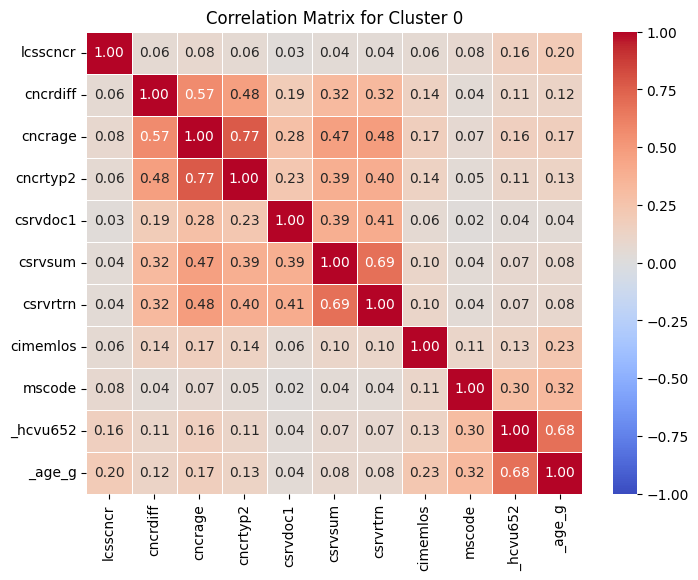

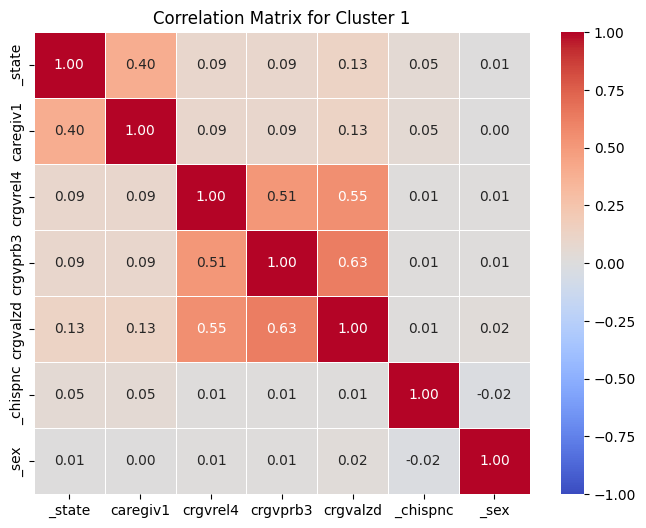

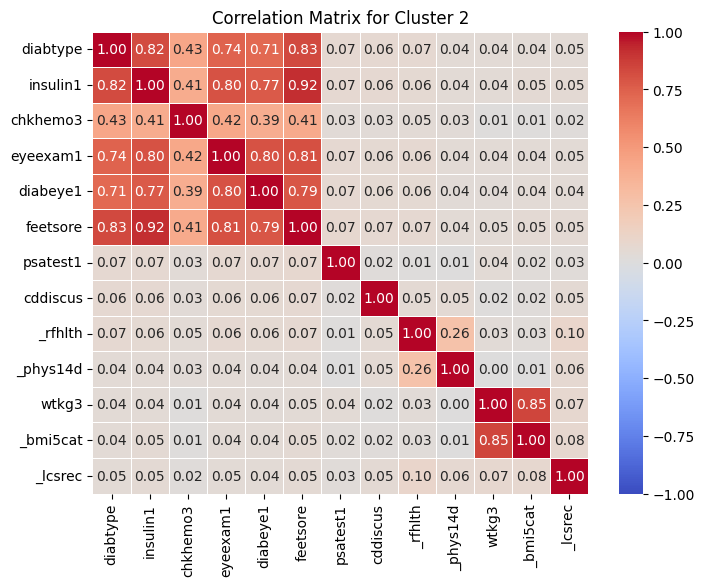

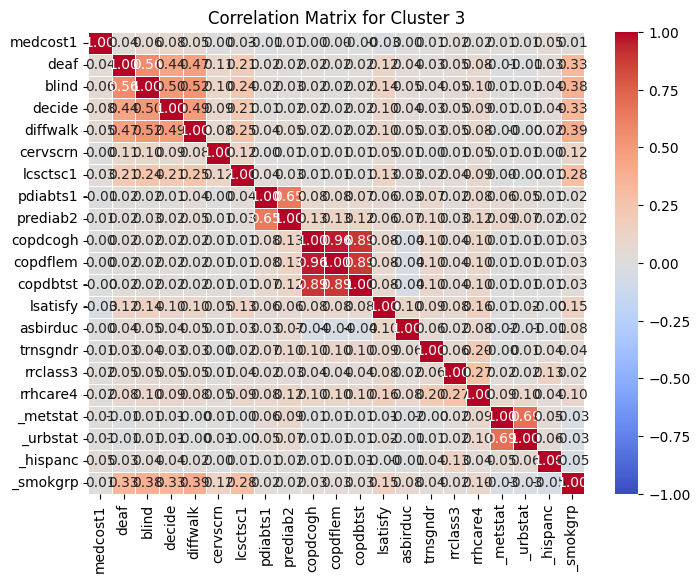

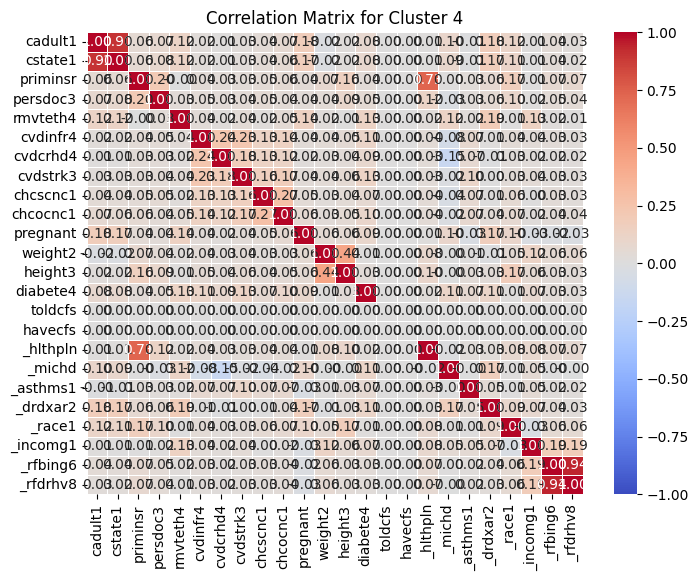

In [66]:
# Compute the correlation matrix
correlation_matrix = fsm.corr()

# Check for NaNs in the correlation matrix
if correlation_matrix.isnull().values.any():
    print("NaNs detected in the correlation matrix.")
    # Impute NaNs with 0 in the correlation matrix
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    correlation_matrix = pd.DataFrame(imputer.fit_transform(correlation_matrix), index=correlation_matrix.index, columns=correlation_matrix.columns)

# Flatten correlation matrix and standardize for clustering
corr_matrix_flat = correlation_matrix.values
scaler = StandardScaler()
scaled_corr_matrix = scaler.fit_transform(corr_matrix_flat)

# Perform K-Means clustering
num_clusters = 5  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(scaled_corr_matrix)

# Create a DataFrame with cluster labels for each feature
feature_clusters = pd.DataFrame({
    'Feature': correlation_matrix.columns,
    'Cluster': clusters
})

# Plot correlation matrices for each cluster
for cluster in range(num_clusters):
    # Get features in the current cluster
    cluster_features = feature_clusters[feature_clusters['Cluster'] == cluster]['Feature']
    cluster_corr_matrix = correlation_matrix.loc[cluster_features, cluster_features]
    
    plt.figure(figsize=(8, 6))  # Set the size of the plot
    sns.heatmap(cluster_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
    plt.title(f'Correlation Matrix for Cluster {cluster}')
    plt.show()

### Feature Clusters

In [69]:
print(feature_clusters)

     Feature  Cluster
0    cadult1        4
1    cstate1        4
2   priminsr        4
3   persdoc3        4
4   medcost1        3
..       ...      ...
71  _incomg1        4
72  _smokgrp        3
73   _lcsrec        2
74  _rfbing6        4
75  _rfdrhv8        4

[76 rows x 2 columns]


In [73]:
feature_clusters['Cluster'].value_counts()

Cluster
4    24
3    21
2    13
0    11
1     7
Name: count, dtype: int64

In [78]:
# Sort feature_clusters by 'Feature'
sorted_feature_clusters = feature_clusters.sort_values(by=['Feature'])

# Create clusters_summary from the sorted DataFrame
clusters_summary = sorted_feature_clusters.groupby('Cluster')['Feature'].apply(list)

# Loop through each unique cluster and print sorted features
for cluster, features in clusters_summary.items():
    print(f"Cluster {cluster}:")
    for feature in features:
        print(f"  {feature}")
    print()  # Blank line for better readability

Cluster 0:
  _age_g
  _hcvu652
  cimemlos
  cncrage
  cncrdiff
  cncrtyp2
  csrvdoc1
  csrvrtrn
  csrvsum
  lcsscncr
  mscode

Cluster 1:
  _chispnc
  _sex
  _state
  caregiv1
  crgvalzd
  crgvprb3
  crgvrel4

Cluster 2:
  _bmi5cat
  _lcsrec
  _phys14d
  _rfhlth
  cddiscus
  chkhemo3
  diabeye1
  diabtype
  eyeexam1
  feetsore
  insulin1
  psatest1
  wtkg3

Cluster 3:
  _hispanc
  _metstat
  _smokgrp
  _urbstat
  asbirduc
  blind
  cervscrn
  copdbtst
  copdcogh
  copdflem
  deaf
  decide
  diffwalk
  lcsctsc1
  lsatisfy
  medcost1
  pdiabts1
  prediab2
  rrclass3
  rrhcare4
  trnsgndr

Cluster 4:
  _asthms1
  _drdxar2
  _hlthpln
  _incomg1
  _michd
  _race1
  _rfbing6
  _rfdrhv8
  cadult1
  chcocnc1
  chcscnc1
  cstate1
  cvdcrhd4
  cvdinfr4
  cvdstrk3
  diabete4
  havecfs
  height3
  persdoc3
  pregnant
  priminsr
  rmvteth4
  toldcfs
  weight2



### diabete4 Correlation

Let's check which features are highly correlated with our target variable, diabete4. We can already get a glimpse of this based on which features were included in the same cluster as the target.

In [83]:
# Compute correlation matrix
correlation_matrix = fsm.corr()

# Extract correlations with 'diabete4'
diabete4_corr = correlation_matrix['diabete4'].sort_values(ascending=False)

# Print correlations with 'diabete4'
print("Correlations with 'diabete4':")
print(diabete4_corr.head(30))
print(diabete4_corr.tail(30))

# Filter out the target variable itself (if you don't want to include it)
high_corr_features = diabete4_corr[diabete4_corr.index != 'diabete4']

# Display highly correlated features (e.g., correlation > 0.5 or < -0.5)
high_corr_features = high_corr_features[(high_corr_features > 0.5) | (high_corr_features < -0.5)]
print("\nHighly correlated features with 'diabete4':")
print(high_corr_features)

Correlations with 'diabete4':
diabete4    1.000000
prediab2    0.227082
pdiabts1    0.157076
cvdstrk3    0.128727
rmvteth4    0.126222
_drdxar2    0.114558
diffwalk    0.113518
_michd      0.110260
cvdinfr4    0.109992
chcocnc1    0.099456
pregnant    0.092717
cvdcrhd4    0.085223
cstate1     0.078653
cadult1     0.077536
_incomg1    0.072352
chcscnc1    0.069425
_asthms1    0.069113
persdoc3    0.053400
lcsctsc1    0.050438
deaf        0.049991
blind       0.043298
priminsr    0.038291
decide      0.034720
height3     0.033117
_rfbing6    0.032106
_hispanc    0.026075
_rfdrhv8    0.025682
_hlthpln    0.024426
_smokgrp    0.018150
medcost1    0.018050
Name: diabete4, dtype: float64
copdcogh   -0.010928
copdflem   -0.011211
lsatisfy   -0.013308
psatest1   -0.013313
csrvsum    -0.014490
csrvrtrn   -0.015286
_metstat   -0.015660
_chispnc   -0.019846
cncrtyp2   -0.021573
cncrdiff   -0.022607
cddiscus   -0.031438
cimemlos   -0.032489
cncrage    -0.032546
mscode     -0.060082
_phys14d   -0.0

##### Change Threshold

Right now, there don't seem to be any features highly correlated with our target. This could change as we continue to drop more from the dataframe. For now, let's set a smaller threshold from 0.5 and -0.5

In [84]:
# Filter out the target variable itself (if you don't want to include it)
high_corr_features = diabete4_corr[diabete4_corr.index != 'diabete4']

# Display highly correlated features (e.g., correlation > 0.5 or < -0.5)
high_corr_features = high_corr_features[(high_corr_features > 0.1) | (high_corr_features < -0.1)]
print("\nHighly correlated features with 'diabete4':")
print(high_corr_features)


Highly correlated features with 'diabete4':
prediab2    0.227082
pdiabts1    0.157076
cvdstrk3    0.128727
rmvteth4    0.126222
_drdxar2    0.114558
diffwalk    0.113518
_michd      0.110260
cvdinfr4    0.109992
_bmi5cat   -0.109473
_rfhlth    -0.122371
_hcvu652   -0.123555
chkhemo3   -0.163754
_age_g     -0.183294
diabeye1   -0.320260
eyeexam1   -0.329582
diabtype   -0.335620
insulin1   -0.371270
feetsore   -0.384525
Name: diabete4, dtype: float64


prediab2: 

pdiabts1